import libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

NeRF network class

In [21]:
class NeRF(torch.nn.Module):
    def __init__(self, positional_encoding_pos=10, positional_encoding_dir=4, hidden_dim=256):
        super(NeRF, self).__init__()

        self.positional_encoding_pos = positional_encoding_pos
        self.positional_encoding_dir = positional_encoding_dir

        self.block1 = torch.nn.Sequential(
            nn.Linear(in_features=positional_encoding_pos * 6,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim),
            nn.ReLU()
        )

        self.block2 = torch.nn.Sequential(
            nn.Linear(in_features=hidden_dim + positional_encoding_pos * 6,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim,out_features=hidden_dim + 1)
        )

        self.block3 = torch.nn.Sequential(
            nn.Linear(in_features=hidden_dim + positional_encoding_dir * 6,out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128,out_features=3),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU()

    def positional_encoding(self, x, L):
        out = []
        for i in range(L):
            out.append(torch.sin(2 ** i * torch.pi * x))
            out.append(torch.cos(2 ** i * torch.pi * x))
        return torch.cat(out, dim=-1)

    def forward(self, pos, dir):
        pos_enc_pos = self.positional_encoding(pos, self.positional_encoding_pos)
        pos_enc_dir = self.positional_encoding(dir, self.positional_encoding_dir)
        x = self.block1(pos_enc_pos)
        x = self.block2(torch.cat((x, pos_enc_pos), dim=-1))
        sigma = self.relu(x[:, -1])
        color = self.block3(torch.cat((x[:, :-1], pos_enc_dir), dim=-1))
        return color, sigma

Forward checking

In [4]:
x = torch.rand((64, 3))
d = torch.rand((64, 3))
net = NeRF()
c, sigma = net(x, d)
print(c.shape)
print(sigma.shape)

torch.Size([64, 3])
torch.Size([64])


Cumulative Transmittance

In [28]:
def calculate_T(sigdel):
    T = torch.cumprod(sigdel, dim=1)
    T = torch.concat((torch.ones((T.shape[0], 1)).to(T.device), T[:, :-1]), dim=1)
    return T

In [12]:
T = calculate_T(torch.rand((2, 5)))

In [27]:
def calculate_C(T, alphas, colors):
    weights = T * alphas
    weights = weights.unsqueeze(2)
    C = (weights * colors).sum(1)
    return C

In [14]:
C = calculate_C(
    T,
    torch.rand((2, 5)),
    torch.rand((2, 5, 3))
)

In [15]:
C

tensor([[0.9653, 0.6755, 1.0447],
        [0.5151, 0.3976, 0.7528]])

In [26]:
def create_t_samples(hn, hf, n_bins, n_rays, device):
    t = torch.linspace(hn, hf, n_bins+1, device=device).expand(n_rays, n_bins+1)
    u = torch.rand(t.shape)
    t = t + (u * ((hf-hn) / n_bins))
    return t[:, :-1]


In [32]:
create_t_samples(0.0, 0.5, 10, 4, T.device)

tensor([[0.0306, 0.0689, 0.1096, 0.1600, 0.2407, 0.2562, 0.3108, 0.3849, 0.4138,
         0.4718],
        [0.0103, 0.0802, 0.1071, 0.1927, 0.2112, 0.2782, 0.3496, 0.3914, 0.4244,
         0.4724],
        [0.0349, 0.0564, 0.1247, 0.1633, 0.2183, 0.2981, 0.3358, 0.3936, 0.4411,
         0.4550],
        [0.0469, 0.0642, 0.1196, 0.1875, 0.2226, 0.2639, 0.3171, 0.3715, 0.4320,
         0.4860]])

In [32]:
def create_ray_points(ray_origins, ray_directions, t):
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)
    return x

Loading dataset

In [2]:
training_dataset = torch.from_numpy(np.load('training_data.pkl', allow_pickle=True))
testing_dataset = torch.from_numpy(np.load('testing_data.pkl', allow_pickle=True))

In [17]:
training_dataset[:,6:].shape

torch.Size([16000000, 3])

Rendering sample image

In [77]:
truncated_dataset = training_dataset[:2_000_000, :]
unique_idx = sorted(list(np.unique(truncated_dataset[:, :3], axis=0, return_index=True)[1]))
# np.split(truncated_dataset[:, 3], unique_idx[1:])

torch.Size([2000000, 9])

In [79]:
unique_truncated_idx

[0,
 160000,
 320000,
 480000,
 640000,
 800000,
 960000,
 1120000,
 1280000,
 1440000,
 1600000,
 1760000,
 1920000]

In [10]:
sample_image = training_dataset[:160_000, :] # first image's rays (160_000 per view)
# sample_images = [training_dataset[160_000 * i:160_000 * (i + 1), :] for i in range(100)] # first image's rays (160_000 per view)

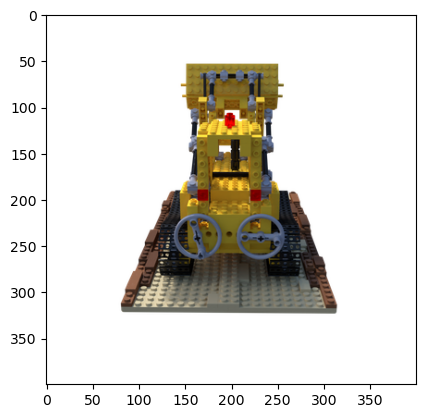

In [19]:
plt.imshow(sample_image[:, 6:].reshape((400, 400, 3)).numpy())
# for i in range(10):
#     plt.figure()
#     plt.imshow(sample_images[i][:, 6:].reshape((400, 400, 3)).numpy())

NeRF Rendering

In [48]:
def nerf_render(model, ray_origins, ray_directions, hn=0.0, hf=0.5, n_bins=192):
    t = create_t_samples(hn=hn, hf=hf, n_bins=n_bins, n_rays=ray_origins.shape[0], device=ray_origins.device)
    query_points = create_ray_points(ray_origins, ray_directions, t) # [batch_size, n_bins, 3]
    query_points = query_points.reshape((-1, 3)) # reshape for network
    query_directions = ray_directions.expand(n_bins, ray_directions.shape[0], 3).transpose(0, 1) # [batch_size, n_bins, 3]
    query_directions = query_directions.reshape((-1, 3)) # reshape for network
    colors, sigmas = model(query_points, query_directions)
    colors = colors.reshape(t.shape[0], t.shape[1], 3)
    sigmas = sigmas.reshape(t.shape[0], t.shape[1])
    deltas = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10]).expand(t.shape[0], 1)), dim=1)
    sigdel_exp = torch.exp(- sigmas * deltas)
    T = calculate_T(sigdel_exp)
    pixel_values = calculate_C(T, 1 - sigdel_exp, colors)
    return pixel_values

In [62]:
model = NeRF()
ray_origins = training_dataset[:1600, :3]
ray_directions = training_dataset[:1600, 3:6]
gt_pixels = training_dataset[:1600, 6:]
loss_fn = nn.MSELoss()

In [55]:
pixel_values = nerf_render(model, ray_origins, ray_directions)

In [56]:
pixel_values.shape

torch.Size([1600, 3])

In [60]:
def train():

    model = NeRF()
    ray_origins = training_dataset[:1600, :3]
    ray_directions = training_dataset[:1600, 3:6]
    gt_pixels = training_dataset[:1600, 6:]

    optimizer = torch.optim.Adam(params=model.parameters(), lr=5e-4)

    for i in range(10):
        pixel_values = nerf_render(model, ray_origins, ray_directions)

        loss = loss_fn(pixel_values, gt_pixels)
        print(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [63]:
train()

tensor(0.3494, grad_fn=<MseLossBackward0>)
tensor(0.2473, grad_fn=<MseLossBackward0>)
tensor(0.2402, grad_fn=<MseLossBackward0>)
tensor(0.2326, grad_fn=<MseLossBackward0>)
tensor(0.2243, grad_fn=<MseLossBackward0>)
tensor(0.2147, grad_fn=<MseLossBackward0>)
tensor(0.2036, grad_fn=<MseLossBackward0>)
tensor(0.1900, grad_fn=<MseLossBackward0>)
tensor(0.1731, grad_fn=<MseLossBackward0>)
tensor(0.1522, grad_fn=<MseLossBackward0>)
